In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, AlphaDropout, BatchNormalization, Add, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size':15})

In [2]:
# Read all datasets
test_feat = pd.read_csv('data/test_features.csv')
train_drug = pd.read_csv('data/train_drug.csv')
train_feat = pd.read_csv('data/train_features.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')

# Categorical to numerical
train_feat.cp_time = train_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
train_feat = pd.get_dummies(train_feat, columns=['cp_type'], prefix="cp_type", drop_first=True)
train_feat = pd.get_dummies(train_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

# Actually this test_features.csv has no targets and is used for making prediction and submitting as submission.csv
# for competition scoring purpose. If I am not going to submit, then it's useless.
test_feat.cp_time = test_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
test_feat = pd.get_dummies(test_feat, columns=["cp_type"], prefix="cp_type", drop_first=True)
test_feat = pd.get_dummies(test_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

# Get X, y using train datasets
X = train_feat.drop('sig_id', axis=1).values
y = train_targets_scored.drop('sig_id', axis=1).values

In [3]:
n_components = 70
pca70 = PCA(n_components=n_components)
X_pca70 = pca70.fit_transform(X)

# first split into train_all and test, latter is used as holdout data.
X_pca70_train_all, X_pca70_test, y_train_all, y_test = train_test_split(X_pca70, y, test_size=0.20, shuffle=True, random_state=1)

# then split train_all to train and val, the former is used as train data, and the latter is used as validation data.
X_pca70_train, X_pca70_val, y_train, y_val = train_test_split(X_pca70_train_all, y_train_all, test_size=0.20, random_state=1)

# X_pca70_train_reshaped = X_pca70_train.reshape(X_pca70_train.shape[0], X_pca70_train.shape[1], 1)
# X_pca70_val_reshaped = X_pca70_val.reshape(X_pca70_val.shape[0], X_pca70_val.shape[1], 1)

In [4]:
X_pca70_train.shape, X_pca70_val.shape, X_pca70_test.shape, y_train.shape, y_val.shape, y_test.shape

((15240, 70), (3811, 70), (4763, 70), (15240, 206), (3811, 206), (4763, 206))

In [5]:
# Need to define the log-loss metric required by the competition, see formula here:
# https://www.kaggle.com/c/lish-moa/overview/evaluation
def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0.001, 0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [6]:
def logloss_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return log_loss(y, y_pred) / y.shape[1]  

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 64)                4544      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dropout_157 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dropout_158 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_217 (Dense)            (None, 206)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
477/477 [==============================] - 3s 4ms/step - loss: 0.4147 - logloss: 0.4140 - val_loss: 0.0235 - val_logloss: 0.0209

Epoch 00001: loss improved from inf to 0.19036, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 2/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0236 - logloss: 0.0209 - val_loss: 0.0213 - val_logloss: 0.0184

Epoch 00002: loss improved from 0.19036 to 0.02303, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 3/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0220 - logloss: 0.0190 - val_loss: 0.0207 - val_logloss: 0.0176

Epoch 00003: loss improved from 0.02303 to 0.02179, saving model to models/mlp_base
INFO:tensorflow:Assets written to: models/mlp_base/assets
Epoch 4/50
477/477 [==============================] - 2s 4ms/step - loss: 0.0212 - logloss: 0.0181 - val_loss: 0.0204 - val_logloss: 0.0172

Epoch 00004: l

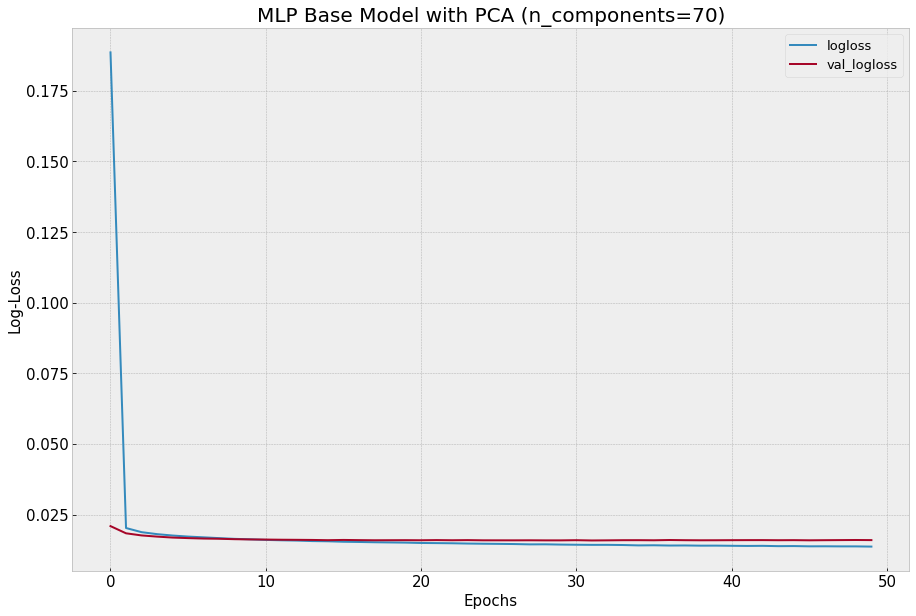

In [66]:
start = time.time()


# Build a basic MLP model first
def build_model(n_cols):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca70_train.shape[1]
mlp_base = build_model(n_cols)
mlp_base.summary()

earlystp_mlp_base = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp_base'
checkpoint_mlp_base = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp_base = mlp_base.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp_base, earlystp_mlp_base, TqdmCallback()])

score = mlp_base.evaluate(X_pca70_val, y_val, verbose=0)
print('Validation log-loss: ', score[1])

mlp_base.save('models/mlp_base_complete')

fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_base.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('MLP Base Model with PCA (n_components=70)', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_base.jpg')


# calculate the running time
end = time.time()
print("Total running time:", round((end - start)/60, 1), 'minutes')

In [53]:
# Hyperparameter tuning with hyperopt library, seems working and fast.
# see https://stackoverflow.com/questions/43533610/how-to-use-hyperopt-for-hyperparameter-optimization-of-keras-deep-learning-netwo


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys

space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,256), 
                    'dropout3': hp.uniform('dropout3', .1,.4)}
                    ]),

            'units1': hp.uniform('units1', 64,256),
            'units2': hp.uniform('units2', 64,256),

            'dropout1': hp.uniform('dropout1', .1,.4),
            'dropout2': hp.uniform('dropout2',  .1,.4),

            #'batch_size' : hp.uniform('batch_size', 28,128),

            #'epochs' :  30,
            #'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(params['units1'], input_dim = X_pca70_train.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(params['units2'])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(params['choice']['units3'])) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(206))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=logloss)

    model.fit(X_pca70_train, y_train, epochs=30, batch_size=32, verbose = 0)

#     pred_auc =model.predict_proba(X_pca70_val, batch_size = 32, verbose = 0)
#     acc = roc_auc_score(y_val, pred_auc)
#     print('AUC:', acc)
#     sys.stdout.flush() 
#     return {'loss': -acc, 'status': STATUS_OK}

#     pred = model.predict(X_pca70_val, batch_size = 32, verbose = 0)
#     logloss_ = logloss(y_val, pred)
    score_logloss = model.evaluate(X_pca70_val, y_val, verbose=0)
    print('Log-Loss:', score_logloss[1])
    sys.stdout.flush() 
    return {'loss': score_logloss[1], 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

Params testing:                                       
{'activation': 'relu', 'choice': {'layers': 'two'}, 'dropout1': 0.35131459808890775, 'dropout2': 0.16874552331862575, 'units1': 218.57716638255835, 'units2': 134.68070182111856}
Log-Loss:                                             
0.01640928164124489                                   
Params testing:                                                                  
{'activation': 'relu', 'choice': {'dropout3': 0.30227136160939916, 'layers': 'three', 'units3': 200.23773954728017}, 'dropout1': 0.18070490325464045, 'dropout2': 0.3593747743956156, 'units1': 158.15102305816262, 'units2': 102.7885436666957}
Log-Loss:                                                                        
0.015897998586297035                                                             
Params testing:                                                                   
{'activation': 'relu', 'choice': {'dropout3': 0.15687800410385783, 'layers': 'three', '

**Did learning_rate, decay, label smoothing, batch size optimization manually in cap3_linux.ipynb. Take those optimized parameters, directly combine with above parameters to build final model.**

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_218 (Dense)            (None, 134)               9514      
_________________________________________________________________
batch_normalization_18 (Batc (None, 134)               536       
_________________________________________________________________
dropout_159 (Dropout)        (None, 134)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 255)               34425     
_________________________________________________________________
batch_normalization_19 (Batc (None, 255)               1020      
_________________________________________________________________
dropout_160 (Dropout)        (None, 255)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 166)             

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/500
477/477 [==============================] - 3s 5ms/step - loss: 0.6200 - logloss: 0.6197 - val_loss: 0.0454 - val_logloss: 0.0436

Epoch 00001: loss improved from inf to 0.38669, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 2/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0432 - logloss: 0.0412 - val_loss: 0.0243 - val_logloss: 0.0217

Epoch 00002: loss improved from 0.38669 to 0.03539, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 3/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0262 - logloss: 0.0235 - val_loss: 0.0227 - val_logloss: 0.0197

Epoch 00003: loss improved from 0.03539 to 0.02540, saving model to models/mlp_final
INFO:tensorflow:Assets written to: models/mlp_final/assets
Epoch 4/500
477/477 [==============================] - 2s 5ms/step - loss: 0.0244 - logloss: 0.0214 - val_loss: 0.0220 - val_logloss: 0.0188

Epoc

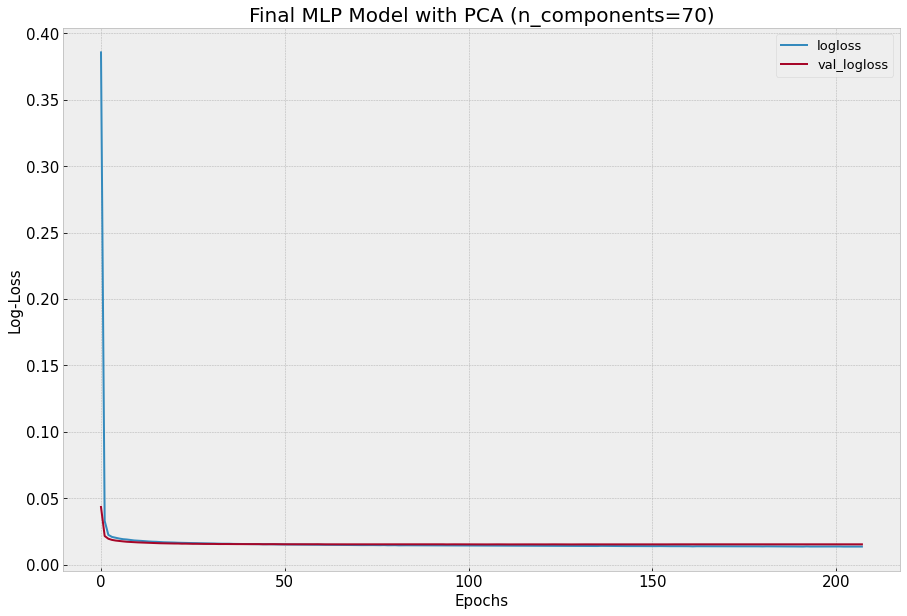

In [67]:
# To record running time
start = time.time()

# build final model with optimized hyperparameters, print model summary
def mlp_model(n_cols):
    model = Sequential()
    model.add(Dense(134, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.379))
    model.add(Dense(255, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.217))
    model.add(Dense(166, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.325))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.0005, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca70_train.shape[1]
mlp_final = mlp_model(n_cols)
mlp_final.summary()

# setup callbacks for fitting
earlystp_mlp_final = EarlyStopping(monitor='loss', patience=10)
filepath = 'models/mlp_final'
checkpoint_mlp_final = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# fit the model
history_mlp_final = mlp_final.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=500,
    callbacks=[checkpoint_mlp_final, earlystp_mlp_final, TqdmCallback()])

# evaluate model with validation data
score = mlp_final.evaluate(X_pca70_val, y_val, verbose=0)
print('Validation log-loss: ', score[1])

# save the model
mlp_final.save('models/mlp_final_complete')

# plot training history of the model
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_final.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('Final MLP Model with PCA (n_components=70)', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_final.jpg')

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')


In [68]:
y_test_pred = mlp_final.predict(X_pca70_test)
y_test_pred.shape, y_test_pred[0,:]

((4763, 206),
 array([4.26311686e-04, 3.15509387e-04, 6.81524049e-04, 5.53430617e-03,
        1.56197082e-02, 7.14969356e-03, 4.46298718e-03, 2.81365751e-03,
        2.82501249e-04, 1.67086273e-02, 2.72273663e-02, 1.21686971e-04,
        1.65818070e-04, 1.22064550e-04, 1.60292734e-03, 2.32351391e-04,
        2.15103826e-03, 1.09791756e-03, 8.11889675e-03, 3.15964245e-03,
        8.20008689e-04, 1.70584093e-03, 3.87792446e-04, 1.06420461e-03,
        1.18138990e-03, 3.01843800e-04, 5.62351721e-04, 3.68266512e-04,
        7.24778324e-03, 2.83170422e-03, 5.22994727e-04, 1.28603401e-03,
        4.98053036e-04, 2.46029405e-04, 5.00624243e-04, 2.47914344e-04,
        4.19031456e-03, 1.95220549e-04, 2.81328015e-04, 4.37082723e-04,
        2.32636323e-03, 2.49067508e-03, 1.91137916e-03, 9.85627156e-03,
        1.27282704e-03, 2.22069095e-03, 1.97914356e-04, 8.20291578e-04,
        2.11449820e-04, 3.45877558e-03, 1.01739739e-03, 1.41989114e-03,
        3.47551832e-04, 1.06922619e-03, 1.48599707

In [69]:
test_score = mlp_final.evaluate(X_pca70_test, y_test, verbose=0)[1]
test_score

0.015728436410427094

**Final logloss on holdout data is 0.0157.**

Play around more:

In [70]:
np.array(history_mlp_final.history['val_logloss']).min()

0.015394747257232666

In [71]:
mlp_final.evaluate(X_pca70_val, y_val, verbose=0)[1]

0.015460934489965439

looks like the best model is somewhere in the 208 epochs. So load it from callbacks, and re-calculate the best score for validation data.

In [72]:
# With custom object, have to do following to load model, otherwise, will always throw errors here or later
best_model = load_model('models/mlp_final', compile=False, custom_objects={"logloss": logloss})
best_model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

In [73]:
best_model.evaluate(X_pca70_val, y_val, verbose=0)[1]

0.01547936163842678

Seems even I loaded the best model (because I saved only best model in callbacks), still not gave the lowest logloss? Problem comes from the reload??? Try to fit more and see.

In [74]:
best_model.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=10)

Epoch 1/10
477/477 [==============================] - 3s 4ms/step - loss: 0.0175 - logloss: 0.0142 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 2/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 3/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0190 - val_logloss: 0.0156
Epoch 4/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 5/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 6/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 7/10
477/477 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0144 - val_loss: 0.0190 - val_logloss: 0.0155
Epoch 8/10
477/477 [

In [75]:
best_model.evaluate(X_pca70_val, y_val, verbose=0)[1]

0.015506485477089882

Even worse!!! So stop here.

In [78]:
# Hyperparameter tuning with hyperopt library, seems working and fast.
# see https://stackoverflow.com/questions/43533610/how-to-use-hyperopt-for-hyperparameter-optimization-of-keras-deep-learning-netwo
# try to add batch_size and learning rate as hyperparameters.

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys

space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,256), 
                    'dropout3': hp.uniform('dropout3', .1,.5)}
                    ]),

            'units1': hp.uniform('units1', 64,256),
            'units2': hp.uniform('units2', 64,256),

            'dropout1': hp.uniform('dropout1', .1,.5),
            'dropout2': hp.uniform('dropout2',  .1,.5),

            'batch_size': hp.choice('batch_size', [32,64,128,256]),  #has to be int32, cannot use hp.uniform

            'learn_rate': hp.uniform('learn_rate', 0.0001,0.001),
            #'epochs' :  30,
            #'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(params['units1'], input_dim = X_pca70_train.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(params['units2'])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(params['choice']['units3'])) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(206))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=params['learn_rate'], decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    model.fit(X_pca70_train, y_train, epochs=30, batch_size=params['batch_size'], verbose = 0)

#     pred_auc =model.predict_proba(X_pca70_val, batch_size = 32, verbose = 0)
#     acc = roc_auc_score(y_val, pred_auc)
#     print('AUC:', acc)
#     sys.stdout.flush() 
#     return {'loss': -acc, 'status': STATUS_OK}

#     pred = model.predict(X_pca70_val, batch_size = 32, verbose = 0)
#     logloss_ = logloss(y_val, pred)
    score_logloss = model.evaluate(X_pca70_val, y_val, verbose=0)
    print('Log-Loss:', score_logloss[1])
    sys.stdout.flush() 
    return {'loss': score_logloss[1], 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

Params testing:                                       
{'activation': 'relu', 'batch_size': 256, 'choice': {'dropout3': 0.20096682915867073, 'layers': 'three', 'units3': 65.1701393644116}, 'dropout1': 0.4490989767251067, 'dropout2': 0.10005130704392862, 'learn_rate': 0.00024647911577451115, 'units1': 92.01021022429563, 'units2': 125.58026541235671}
Log-Loss:                                             
0.019952604547142982                                  
Params testing:                                                                   
{'activation': 'relu', 'batch_size': 32, 'choice': {'dropout3': 0.22947026236945753, 'layers': 'three', 'units3': 209.8354751804819}, 'dropout1': 0.34135003794646634, 'dropout2': 0.44715722668535285, 'learn_rate': 0.00016628448410201577, 'units1': 235.23851448418333, 'units2': 140.6480292312059}
Log-Loss:                                                                         
0.017096811905503273                                                        

Fine-tuning the batch size (note, should be 32 not 0 if check back the output log) and learning rate is not better than previous tuning. Actually got batch size 32 and very similar learning rate. So really stop here. 